In [ ]:
import gym
from gym import spaces
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb


# additional imports
from stable_baselines3 import PPO
from stable_baselines3.ppo import MlpPolicy
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_checker import check_env

In [ ]:
class Agent():
    def __init__(self,cx = 50, cy=50, r= 50, ownship = False ):
        self.icon = self.load_icon()
        self.CX = cx
        self.CY = cy
        self.R = r
        self.Ownship = ownship
        # self.offset = offset
        if ownship == True:
            init_angle = np.pi
            x = int(r*np.cos(init_angle)+cx)
            y = int(r*np.sin(init_angle)+cy)
        else:
            # init_angle = (np.random.random()-0.5)*4*np.pi/3 # random position of intruder from -120 to 120 degree.
            # init_angle = np.random.choice([0, np.pi/6, np.pi/3, -np.pi/6, -np.pi/3]) # few choices of conflict angles
            init_angle = 0 # head-on conflict
            offset = 0
            x = int(r*np.cos(init_angle)+cx) + offset
            y = int(r*np.sin(init_angle)+cy) + offset

        self.position = np.array([x,y])
        self.heading = init_angle + np.pi
        self.speed = 10


    def step(self, new_heading):
        self.heading = new_heading

        self.position[0] = np.clip(self.position[0] + self.speed*np.cos(new_heading), 0, self.R*2)
        self.position[1] = np.clip(self.position[1] + self.speed*np.sin(new_heading), 0, self.R*2)
        return self.position

    def load_icon(self):
        filename = "./Icon/airplane.png"
        icon = Image.open(filename)
        return icon

In [ ]:


class CustomEnv(gym.Env):
    CX, CY, R, SAFE_R = 50, 50, 50, 5


    LEFT, NONE, RIGHT = 1, 0, 2
    ALPHA = 0.25*np.pi # TURNING 45 degrees
    MAX_STEP = 1500
    high = 0.1*np.pi,

    def __init__(self, Reward_Params = [-0.2, -3/50, -10, -1, -10, 10]):
        self.Reward_Params = Reward_Params
        self.agents = [Agent(self.CX,self.CY,self.R, ownship=True), Agent(self.CX,self.CY,self.R)]
        self.reward = 0
        self.n_step = 0
        self.total_reward = 0
        n_observation = np.size(self.observation_func())
        n_action = 1

        self.action_space = spaces.Box(low=-self.ALPHA, high=+self.ALPHA, shape=(n_action, ), dtype=np.float32) # continuous action space
        self.observation_space = spaces.Box(low=0, high=100, shape=(n_observation, ), dtype=np.float64)
        self.distancelist = []

    def reset(self):
        self.agents = [Agent(ownship=True), Agent()]
        self.reward = 0
        self.n_step = 0
        self.total_reward = 0
        observation = self.observation_func()
        self.distancelist = []

        return observation

    def step(self,action):
        self.n_step += 1

        # update ownship heading based on input action
        positions_both_agent = []
        for i in range(len(self.agents)):
            x, y    = self.agents[i].position
            heading = self.agents[i].heading
            speed   = self.agents[i].speed
            positions_both_agent.append((x,y))
            if i == 0:
                heading = heading + action[0]

            # agent i moves to next position with updated heading
            self.agents[i].step(heading)
        # print('both_agents_position', positions_both_agent)
        dist_between_agents = np.linalg.norm(np.array(positions_both_agent[0]) - np.array(positions_both_agent[1]))
        self.distancelist.append(dist_between_agents)
        # print(dist_between_Agents)
        self.done = self.check_stopping_condition()
        self.reward = self.reward_func(action,self.done)
        observation = self.observation_func()

        self.total_reward += self.reward # just for monitoring the model performance.
        ################################
        # Optionally we can pass additional info, we are not using that for now
        info = {}

        return observation, self.reward, self.done, info

    def check_stopping_condition(self):
        done = False
        x,y = self.agents[0].position

        # Compute the X and Y coordinations of the target region.
        x_thres     = self.R*np.cos(np.pi/36) + self.CX
        y_thres_min = self.R*np.sin(-np.pi/36) + self.CY
        y_thres_max = self.R*np.sin(np.pi/36) + self.CY

        dis = np.linalg.norm(self.agents[0].position - np.array([self.CX, self.CY]))

        # The ownship reaches the target region or the Episode steps reaches its limit.
        if ((self.R <= dis <= self.R+2) and (x >= x_thres) and (y_thres_min <= y <= y_thres_max)) or (self.n_step == self.MAX_STEP):
            return True

        return False

    def reward_func(self, action, done):
        """
        Reward = a1 * Reward_Step +
                 a2 * Reward_Deviation +
                 a3 * Reward_LOS +
                 a4 * Reward_Maneuvering +
                 a5 * Reward_Not_Reached +
                 a6 * Reward_Reached
        """
        a1 = self.Reward_Params[0]
        a2 = self.Reward_Params[1]
        a3 = self.Reward_Params[2]
        a4 = self.Reward_Params[3]
        a5 = self.Reward_Params[4]
        a6 = self.Reward_Params[5]

        ####################


        Reward_Step = 1

        # Current deviation/distance from the original route
        Reward_Deviation = abs(self.agents[0].position[1] - self.CY)

        Reward_LOS = 0
        Reward_Maneuvering = 0
        Reward_Not_Reached = 0
        Reward_Reached =0

        # Distance between two aircraft for Loss-of-Separation constraint
        dis = np.linalg.norm(self.agents[0].position - self.agents[1].position)

        Reward_LOS = 0
        if dis < self.SAFE_R*2:
            Reward_LOS = 1

        # Turning action
        Reward_Maneuvering = abs(action[0])

        # Completed episode: reach or not reach the target exit region.
        if done:
            if self.n_step == self.MAX_STEP:
                Reward_Not_Reached = 1
            else:
                Reward_Reached = 1

        reward = a1 * Reward_Step + a2 *Reward_Deviation + a3 * Reward_LOS + a4 * Reward_Maneuvering + \
                    a5 * Reward_Not_Reached + a6 * Reward_Reached

        return reward

    # Extract observation or feature vector from the current state.
    def observation_func(self):
        observation = []
        # aircraft position and current heading as features
        for i in range(len(self.agents)):
            observation.extend(self.agents[i].position/self.R)
            observation.append(self.agents[i].heading/np.pi)

        observation.extend(np.zeros(12)) # to keep the obervation space similar to the next env observation space
        observation = np.array(observation)
        return observation

    def render(self, show=False, folder='./Images/'):
        # """ to show scenario images and create images for gifs"""
        fig, ax = plt.subplots(figsize=(10,10))

        # draw the circle as the sector.
        circle1 = plt.Circle((self.CX, self.CY), self.R, color='black', fill=False)
        ax.add_patch(circle1)
        ax.set_xlim((-20, self.R*2+20))
        ax.set_ylim((-20, self.R*2+20))

        # draw the each agent with its stored icon
        for i in range(len(self.agents)):
            x, y = self.agents[i].position
            heading = self.agents[i].heading
            ahead = self.agents[i].speed
            x1, y1 = x + ahead*np.cos(heading), y + ahead*np.sin(heading)

            # load the aircraft icon
            icon = self.agents[i].icon
            rotated = icon.rotate(heading/np.pi*180-90)

            ax.imshow(rotated, extent=[x-2,x+2,y-2,y+2])

            circle_i = plt.Circle((x, y), self.SAFE_R, fill=False)
            ax.add_patch(circle_i)

            ax.plot([x,x1],[y,y1])
            ax.set_title("Step {} - Reward {:.3f} - Total Reward {:.3f}".format(self.n_step,self.reward,self.total_reward))
        ax.axis('scaled')

        if show:
            plt.show()
        else:
            plt.savefig(folder + "image_{:0>3}.png".format(self.n_step))

        return fig

    def close (self):
        pass

In [ ]:
env.action_space

Box([-0.7853982], [0.7853982], (1,), float32)

In [ ]:
# loading the trained model

name = 'CustomEnv_PPO_crossing_all'
model = PPO.load("./Models/CustomEnv/circle/" +name)

env = CustomEnv()
check_env(env)

c:\Users\YASH009\AppData\Local\anaconda3\envs\rl2\lib\site-packages\stable_baselines3\common\env_checker.py:272: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


In [ ]:
n_scenarios = 10
results = []
distancelist = []
total_reward_list = []

for runs in range(n_scenarios):
    obs = env.reset()
    done = False
    total_reward = 0
    distance_between_agents = []
    detailed_results = [] # to check action, reward and done status at each step
    while not done:
        action, state_ = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        total_reward += reward
        detailed_results.append([action, reward, done])
        # distance_between_agents.append(dist_between_agents)

    distancelist.append(env.distancelist)
    total_reward_list.append(total_reward)




### Plotting the collected data

In [ ]:
total_reward_list

[-7.279791237115857,
 -7.279791237115857,
 -7.279791237115857,
 -7.279791237115857,
 -7.279791237115857,
 -7.279791237115857,
 -7.279791237115857,
 -7.279791237115857,
 -7.279791237115857,
 -7.279791237115857]

In [ ]:
distancelist

[[100.0,
  81.00617260431454,
  62.07253821135398,
  43.289721643826724,
  25.0,
  9.433981132056603,
  16.64331697709324,
  34.20526275297414,
  52.61178575186362,
  71.34423592694787,
  90.19977827023745,
  99.12618221237011],
 [100.0,
  81.00617260431454,
  62.07253821135398,
  43.289721643826724,
  25.0,
  9.433981132056603,
  16.64331697709324,
  34.20526275297414,
  52.61178575186362,
  71.34423592694787,
  90.19977827023745,
  99.12618221237011],
 [100.0,
  81.00617260431454,
  62.07253821135398,
  43.289721643826724,
  25.0,
  9.433981132056603,
  16.64331697709324,
  34.20526275297414,
  52.61178575186362,
  71.34423592694787,
  90.19977827023745,
  99.12618221237011],
 [100.0,
  81.00617260431454,
  62.07253821135398,
  43.289721643826724,
  25.0,
  9.433981132056603,
  16.64331697709324,
  34.20526275297414,
  52.61178575186362,
  71.34423592694787,
  90.19977827023745,
  99.12618221237011],
 [100.0,
  81.00617260431454,
  62.07253821135398,
  43.289721643826724,
  25.0,
  9

In [ ]:
CPA = []
for i in range(len(distancelist)):
    min_dist = min(distancelist[i])
    CPA.append(min_dist)

<Axes: ylabel='Count'>

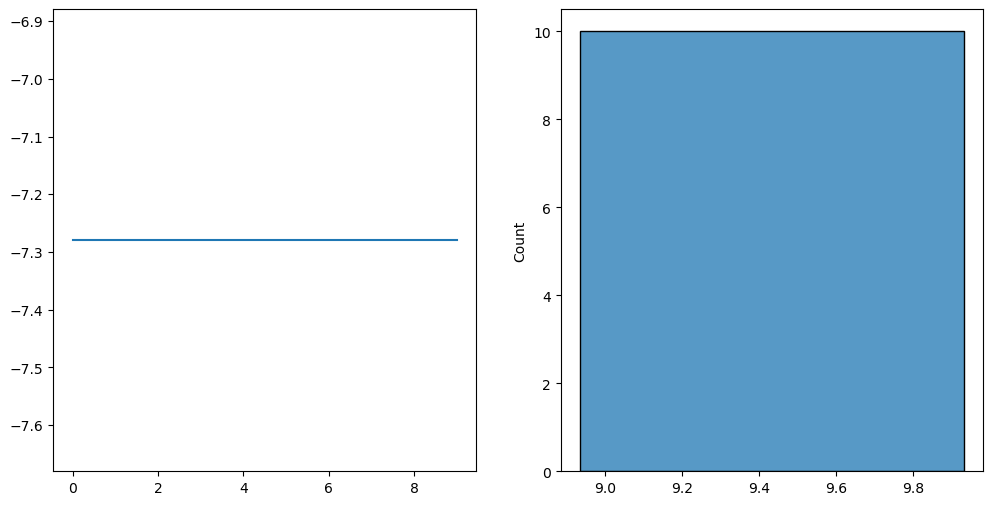

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (12,6))
ax[0].plot(total_reward_list)
sb.histplot(CPA, ax = ax[1])